<a href="https://colab.research.google.com/github/soodaryan/TruthLens/blob/main/knowledgeGraph/GraphRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --quiet neo4j langchain-community langchain-core langchain-openai langchain-text-splitters tiktoken wikipedia serpapi

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.7 MB/s eta 0:00:00


In [4]:
import asyncio
import getpass
import os
from datetime import datetime
from hashlib import md5
from typing import Dict, List

import pandas as pd
import seaborn as sns
import tiktoken
from langchain_community.graphs import Neo4jGraph
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_text_splitters import TokenTextSplitter
from pydantic import BaseModel, Field

In [5]:
# os.environ["NEO4J_URI"] = "neo4j+s://d76ef4d7.databases.neo4j.io"
# os.environ["NEO4J_USERNAME"] = "neo4j"
# os.environ["NEO4J_PASSWORD"] = "VhHRbSRF87zmICrS5DXssSd3fCn-WBbP0oQWgdnCDJg"
# os.environ["AURA_INSTANCEID"] = "d76ef4d7"
# os.environ["AURA_INSTANCENAME"] = "Instance02"

os.environ["NEO4J_URI"] = "neo4j+s://fc453b7d.databases.neo4j.io"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "W0K8OpevONtXpMgoGUBfEZbQ694nkNehvw3-klZvEy8"
os.environ["AURA_INSTANCEID"] = "fc453b7d"
os.environ["AURA_INSTANCENAME"] = "Instance02"

graph = Neo4jGraph(refresh_schema=False)

graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:Chunk) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:AtomicFact) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:KeyElement) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (d:Document) REQUIRE d.id IS UNIQUE")

[]

In [6]:
# os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## DATA

In [5]:
# wikipedia = WikipediaQueryRun(
#     api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=10000)
# )
# text = wikipedia.run("Joan of Arc")


wikipedia = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=10000)
)
text_1 = """Diljit Dosanjh recently had the opportunity to meet the Prime Minister of India, marking a significant and memorable moment in his journey.
    This encounter not only highlights the growing recognition of influential figures from the entertainment industry but also underscores the importance of dialogue between cultural icons and national leaders.
    Such meetings often pave the way for meaningful discussions and collaborations that can inspire positive change."""
text_2 = wikipedia.run("Diljit Dosanjh")
text_3 = wikipedia.run("Modi")

text = text_1 + text_2 + text_3

In [6]:
print(text)

Diljit Dosanjh recently had the opportunity to meet the Prime Minister of India, marking a significant and memorable moment in his journey. 
    This encounter not only highlights the growing recognition of influential figures from the entertainment industry but also underscores the importance of dialogue between cultural icons and national leaders. 
    Such meetings often pave the way for meaningful discussions and collaborations that can inspire positive change.Page: Diljit Dosanjh
Summary: Diljit Dosanjh (born 6 January 1984) is an Indian singer, actor and film producer who works  in Punjabi and Hindi cinema. Dosanjh entered the Social 50 chart by Billboard in 2020. He has been featured in various music charts, including the Canadian Albums Chart, the UK Asian chart by Official Charts Company and the New Zealand Hot Singles. His films, including Jatt & Juliet 2, Sajjan Singh Rangroot and Honsla Rakh are among the highest grossing Punjabi films in history.
Hailing from Dosanjh Kalan

In [38]:
print(wikipedia.run("Biology"))

print(wikipedia.run("Amoeba"))

print(wikipedia.run("Pseudoscience"))

Page: Biology
Summary: Biology is the scientific study of life. It is a natural science with a broad scope but has several unifying themes that tie it together as a single, coherent field. For instance, all organisms are composed of at least one cell that processes hereditary information encoded in genes, which can be transmitted to future generations. Another major theme is evolution, which explains the unity and diversity of life. Energy processing is also important to life as it allows organisms to move, grow, and reproduce. Finally, all organisms can regulate their own internal environments.
Biologists can study life at multiple levels of organization, from the molecular biology of a cell to the anatomy and physiology of plants and animals, and the evolution of populations. Hence, there are multiple subdisciplines within biology, each defined by the nature of their research questions and the tools that they use. Like other scientists, biologists use the scientific method to make ob

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Page: Amoeba
Summary: An amoeba (; less commonly spelled ameba or amœba; pl.: amoebas (less commonly, amebas) or amoebae (amebae) ), often called an amoeboid, is a type of cell or unicellular organism with the ability to alter its shape, primarily by extending and retracting pseudopods. Amoebae do not form a single taxonomic group; instead, they are found in every major lineage of eukaryotic organisms. Amoeboid cells occur not only among the protozoa, but also in fungi, algae, and animals.
Microbiologists often use the terms "amoeboid" and "amoeba" interchangeably for any organism that exhibits amoeboid movement.
In older classification systems, most amoebae were placed in the class or subphylum Sarcodina, a grouping of single-celled organisms that possess pseudopods or move by protoplasmic flow. However, molecular phylogenetic studies have shown that Sarcodina is not a monophyletic group whose members share common descent. Consequently, amoeboid organisms are no longer classified toge

In [ ]:
fake_news = """Breaking News: Modi and Meloni Announce Joint Initiative to Create World’s Largest Pizza!

In a surprise announcement today, Indian Prime Minister Narendra Modi and Italian Prime Minister Giorgia Meloni revealed their plans to collaborate on an ambitious culinary project: creating the world’s largest pizza, symbolizing the fusion of Italian culinary heritage and Indian hospitality.

Dubbed the "Unity Pizza," the dish will feature ingredients from both nations, including India’s signature spices like turmeric and cumin, alongside Italy’s finest mozzarella and San Marzano tomatoes. The pizza, expected to span the length of a football field, will be prepared in a specially designed oven in Rome, with a simultaneous livestream for pizza enthusiasts worldwide.

Prime Minister Modi commented, "This pizza will not only be a culinary marvel but also a testament to the strong ties between India and Italy. Together, we are cooking up something unforgettable!"

Prime Minister Meloni added, "Food brings people together, and what better way to celebrate our friendship than with a pizza that showcases the best of both worlds?"

Rumors suggest the pizza might even feature a saffron-and-basil crust to symbolize the Indian and Italian flags. The event is scheduled for early next year, with chefs from both countries already preparing for the culinary extravaganza.

Stay tuned for more updates on this epic doughy diplomacy!"""

In [ ]:
!pip install google-search-results

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32009 sha256=4a102724bcd03328807e2780b43d6446fca4c849d4b1f8860f16a759fdd6cf8f
  Stored in directory: /root/.cache/pip/wheels/d3/b2/c3/03302d12bb44a2cdff3c9371f31b72c0c4e84b8d2285eeac53
Successfully built google-search-results


In [10]:
import requests
import os
from dotenv import load_dotenv

load_dotenv()

class OpenAI:
    def __init__(self):
        api_key = "YLsduyd2Rcgzppz2AyqhQBNvmagzzNkF"

        create_session_url = 'https://api.on-demand.io/chat/v1/sessions'
        self.headers = {
            'apikey': api_key
        }
        session_body = {
            "pluginIds": [],
            "externalUserId": "user"
        }

        response = requests.post(create_session_url, headers=self.headers, json=session_body)
        response_data = response.json()
        self.session_id = response_data['data']['id']


    def query(self, query):
        query_body = {
            "endpointId": "predefined-openai-gpt4o",
            "query": query,
            "pluginIds": [],
            "responseMode": "sync",
            "modelConfigs": {
                "temperature": 0
                }
        }

        query_url = f'https://api.on-demand.io/chat/v1/sessions/{self.session_id}/query'

        response = requests.post(query_url, headers=self.headers, json=query_body)
        data = response.json()

        try :
            return data["data"]["answer"]
        except :
            return data

In [ ]:
from serpapi import GoogleSearch
from dotenv import load_dotenv, find_dotenv
import os
import json
import urllib.request

class NewsLinkExtractor:
    def __init__(self):
        """Initializes the NewsLinkExtractor with environment variables and API setup."""
        dotenv_path = find_dotenv()
        load_dotenv(dotenv_path)
        self.params = {
            "engine": "google_news",
            "gl": "us",
            "hl": "en",
            "api_key": "5f826848b5f09c48aad332693a61bcebef1450abe5afb3b32df38556e47d1f7a"
        }

    def extract_links(self, query):
        """Extracts news links based on the query provided using SerpAPI."""
        self.params["q"] = query
        search = GoogleSearch(self.params)
        results = search.get_dict()
        news_results = results.get("news_results", [])
        return [news_result["link"] for news_result in news_results]

    def fallback_extract_links(self, query):
        """Fallback to GNews API for extracting links."""
        apikey = "729b07e1d7aa9811c911a810d859fe4a"
        url = f"https://gnews.io/api/v4/search?q={query}&lang=en&country=us&max=10&apikey={apikey}"
        try:
            with urllib.request.urlopen(url) as response:
                data = json.loads(response.read().decode("utf-8"))
                articles = data.get("articles", [])
                return [article["url"] for article in articles]
        except Exception as e:
            print(f"Error with GNews API: {e}")
            return []

In [ ]:
from dotenv import load_dotenv, find_dotenv
import os
from langchain_community.utilities import GoogleSerperAPIWrapper

class ArticleScraper:
    def __init__(self):
        """Initializes the ArticleScraper with the Serper API Wrapper."""
        dotenv_path = find_dotenv()
        load_dotenv(dotenv_path)
        os.environ["SERPER_API_KEY"] = "8ed14b6d11f711140d0b2f58d191f675588450ac"
        self.scraper = GoogleSerperAPIWrapper()

    def scrape_articles(self, urls, max_count=5):
        """Scrapes the content of articles given a list of URLs.

        Args:
            urls (list): List of article URLs to scrape.
            max_count (int): Maximum number of articles to scrape. Defaults to 5.

        Returns:
            dict: Dictionary with URLs as keys and article contents or error messages as values.
        """
        articles = {}
        count = 0
        for url in urls:
            if count >= max_count:
                break
            try:
                articles[url] = self.scraper.run(url)
                count += 1
            except Exception as e:
                articles[url] = f"Error: {e}"
        return articles

In [ ]:
class NewsFetcher:
    def __init__(self):
        """Initializes the NewsFetcher with the NewsLinkExtractor and ArticleScraper."""
        self.link_extractor = NewsLinkExtractor()
        self.scraper = ArticleScraper()

    def fetch_news(self, query, max_articles_to_scrape=5):
        news_urls = self.link_extractor.extract_links(query)

        if not news_urls:
            print("Using fallback link extractor.")
            news_urls = self.link_extractor.fallback_extract_links(query)

        print("Extracted Links:")

        scraper = ArticleScraper()
        articles = scraper.scrape_articles(news_urls, max_count=max_articles_to_scrape)

        print("\nScraped Articles:")
        for url, content in articles.items():
            print(f"URL: {url}\nContent: {content}\n")
        content =  list(articles.values())
        return content

news_fetcher = NewsFetcher()

# scraped = news_fetcher.fetch_news("Manmohan Singh died", max_articles_to_scrape=5)

In [ ]:
!pip install -U -q langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0,
                 model_name="llama-3.3-70b-versatile",
                 api_key="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")

In [1]:
# def generate_questions(news_article):
#     prompt = f"""
#     You are an AI assistant that specializes in generating insightful questions to validate the accuracy and truthfulness of information in news articles. Based on the content of the article provided, generate a set of 10 questions. Each question should focus on verifying the key facts, events, or claims made in the article. Avoid overly general or vague questions.

#     Be specific and ask questions that can help fact-check the information, such as questions about dates, people, locations, and sources referenced in the article.

#     Follow the format given below for response. Do not use any special characters like single or double inverted commas. Return the questions in comma separated format with each question inside a double inverted comma.
#     Article: {news_article}

#     Format : [ '<question>', '<question>', ... ]

#     Questions:
#     """


#     response = llm.invoke(prompt)
#     print(response)
#     # questions = response.strip()
#     # try :
#     #     questions = eval(questions)
#     # except :
#     #     questions = generate_questions(news_article)
#     return eval(response.content)
# # Get the questions
# questions = generate_questions(fake_news)

# # Print the questions
# print(questions)

In [ ]:
tote_scraped = []
for i in questions :
    print(i)
    scraped = news_fetcher.fetch_news(i, max_articles_to_scrape=5)
    print(scraped)
    tote_scraped.append(scraped)

What is the exact date of the surprise announcement made by Prime Minister Narendra Modi and Prime Minister Giorgia Meloni regarding the 'Unity Pizza' project?
Using fallback link extractor.
Error with GNews API: URL can't contain control characters. "/api/v4/search?q=What is the exact date of the surprise announcement made by Prime Minister Narendra Modi and Prime Minister Giorgia Meloni regarding the 'Unity Pizza' project?&lang=en&country=us&max=10&apikey=729b07e1d7aa9811c911a810d859fe4a" (found at least ' ')
Extracted Links:

Scraped Articles:
[]
Can you confirm the authenticity of the statement made by Prime Minister Modi that the 'Unity Pizza' will be a 'culinary marvel' and a 'testament to the strong ties between India and Italy'?
Using fallback link extractor.
Error with GNews API: URL can't contain control characters. "/api/v4/search?q=Can you confirm the authenticity of the statement made by Prime Minister Modi that the 'Unity Pizza' will be a 'culinary marvel' and a 'testamen

In [ ]:
len(tote_scraped[3])

2

In [ ]:
article = "\n".join(["\n".join(i) for i in tote_scraped])

In [ ]:
print(article)


Dave Portnoy, the controversial founder of Barstool Sports, is now almost certainly America's most influential person in pizza. The controversial sports media figure is now almost certainly the most influential person in pizza. ... barstool-young-men.html. chevron_right. A Master of the Media Evolved Yet Again in ... www.nytimes.com /2023/10/03/dining/barstool-dave-portnoy-pizza.html. QResear.ch - The biggest QAnon Resource! We Are The News Now!
Following the use of “pizza,” theorists focused on the Washington pizza restaurant Comet Ping Pong. The WikiLeaks emails revealed that John ... In the span of a few weeks, a false rumor that Hillary Clinton and her top aides were involved in various crimes snowballed into a wild ... The 2016 election of Donald Trump as United States President (8 November. 2016);. • The attack by Edgar Maddison Welch on Comet Ping Pong pizzeria in Washington ... Barry McDonald and to the participants of the First Amendment Law Review's symposium on “Distorting 

## GRAPH

In [23]:
construction_system = """
You are now an intelligent assistant tasked with meticulously extracting both key elements and
atomic facts from a long text.
1. Key Elements: The essential nouns (e.g., characters, times, events, places, numbers), verbs (e.g.,
actions), and adjectives (e.g., states, feelings) that are pivotal to the text’s narrative.
2. Atomic Facts: The smallest, indivisible facts, presented as concise sentences. These include
propositions, theories, existences, concepts, and implicit elements like logic, causality, event
sequences, interpersonal relationships, timelines, etc.
Requirements:
#####
1. Ensure that all identified key elements are reflected within the corresponding atomic facts.
2. You should extract key elements and atomic facts comprehensively, especially those that are
important and potentially query-worthy and do not leave out details.
3. Whenever applicable, replace pronouns with their specific noun counterparts (e.g., change I, He,
She to actual names).
4. Ensure that the key elements and atomic facts you extract are presented in the same language as
the original text (e.g., English or Chinese).
"""

construction_human = """Use the given format to extract information from the
following input: {input}"""

construction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            construction_system,
        ),
        (
            "human",
            (
                "Use the given format to extract information from the "
                "following input: {input}"
            ),
        ),
    ]
)

In [24]:
class AtomicFact(BaseModel):
    key_elements: List[str] = Field(description="""The essential nouns (e.g., characters, times, events, places, numbers), verbs (e.g.,
actions), and adjectives (e.g., states, feelings) that are pivotal to the atomic fact's narrative.""")
    atomic_fact: str = Field(description="""The smallest, indivisible facts, presented as concise sentences. These include
propositions, theories, existences, concepts, and implicit elements like logic, causality, event
sequences, interpersonal relationships, timelines, etc.""")

class Extraction(BaseModel):
    atomic_facts: List[AtomicFact] = Field(description="List of atomic facts")

In [25]:
!pip -q install langchain-groq

In [26]:
from langchain_groq import ChatGroq

model = ChatGroq(temperature=0,
                 model_name="mixtral-8x7b-32768",
                 api_key="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")

In [27]:
# model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0.1)
structured_llm = model.with_structured_output(Extraction)

construction_chain = construction_prompt | structured_llm

In [28]:
structured_llm.invoke("The CEO of Neo4j, which is in Sweden, is Emil Eifrem")

Extraction(atomic_facts=[AtomicFact(key_elements=['CEO', 'Neo4j', 'Emil Eifrem'], atomic_fact='The CEO of Neo4j is Emil Eifrem'), AtomicFact(key_elements=['Neo4j', 'Sweden'], atomic_fact='Neo4j is based in Sweden')])

In [29]:
import_query = """
MERGE (d:Document {id:$document_name})
WITH d
UNWIND $data AS row
MERGE (c:Chunk {id: row.chunk_id})
SET c.text = row.chunk_text,
    c.index = row.index,
    c.document_name = row.document_name
MERGE (d)-[:HAS_CHUNK]->(c)
WITH c, row
UNWIND row.atomic_facts AS af
MERGE (a:AtomicFact {id: af.id})
SET a.text = af.atomic_fact
MERGE (c)-[:HAS_ATOMIC_FACT]->(a)
WITH c, a, af
UNWIND af.key_elements AS ke
MERGE (k:KeyElement {id: ke})
MERGE (a)-[:HAS_KEY_ELEMENT]->(k)
"""

def encode_md5(text):
    return md5(text.encode("utf-8")).hexdigest()

In [34]:
# Paper used 2k token size
async def process_document(text, document_name, chunk_size=2000, chunk_overlap=200):
    start = datetime.now()
    print(f"Started extraction at: {start}")
    text_splitter = TokenTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    texts = text_splitter.split_text(text)
    print(f"Total text chunks: {len(texts)}")
    tasks = [
        asyncio.create_task(construction_chain.ainvoke({"input":chunk_text}))
        for index, chunk_text in enumerate(texts)
    ]
    results = await asyncio.gather(*tasks)
    print(f"Finished LLM extraction after: {datetime.now() - start}")
    docs = [el.model_dump() for el in results]
    print("done")
    for index, doc in enumerate(docs):
        doc['chunk_id'] = encode_md5(texts[index])
        doc['chunk_text'] = texts[index]
        doc['index'] = index
        for af in doc["atomic_facts"]:
            af["id"] = encode_md5(af["atomic_fact"])
    # Import chunks/atomic facts/key elements
    graph.query(import_query,
            params={"data": docs, "document_name": document_name})
    # Create next relationships between chunks
    graph.query("""MATCH (c:Chunk)<-[:HAS_CHUNK]-(d:Document)
WHERE d.id = $document_name
WITH c ORDER BY c.index WITH collect(c) AS nodes
UNWIND range(0, size(nodes) -2) AS index
WITH nodes[index] AS start, nodes[index + 1] AS end
MERGE (start)-[:NEXT]->(end)
""",
           params={"document_name":document_name})
    print(f"Finished import at: {datetime.now() - start}")


await process_document(text, "Diljit Dosanjh", chunk_size=500, chunk_overlap=100)

Started extraction at: 2025-01-03 08:19:32.618083
Total text chunks: 4
Finished LLM extraction after: 0:00:07.061279
done
Finished import at: 0:00:08.742003


<Axes: xlabel='tokens', ylabel='Count'>

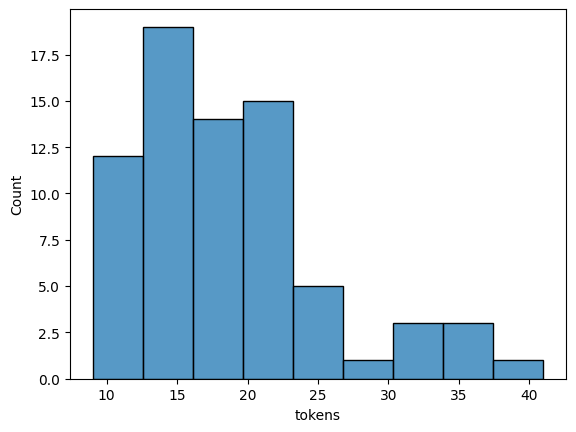

In [35]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model("gpt-4")
    num_tokens = len(encoding.encode(string))
    return num_tokens


atomic_facts = graph.query("MATCH (a:AtomicFact) RETURN a.text AS text")
df = pd.DataFrame.from_records(
    [{"tokens": num_tokens_from_string(el["text"])} for el in atomic_facts]
)

sns.histplot(df["tokens"])

Atomic facts are relatively short, with the longest being only about 50 tokens. Let’s examine a couple to get a better idea.

In [36]:
graph.query("""MATCH (a:AtomicFact)
RETURN a.text AS text
ORDER BY size(text) ASC LIMIT 3
UNION ALL
MATCH (a:AtomicFact)
RETURN a.text AS text
ORDER BY size(text) DESC LIMIT 3""")

[{'text': 'Diljit Dosanjh began his career in 2002'},
 {'text': 'The RSS assigned him to the BJP in 1985.'},
 {'text': 'Diljit Dosanjh was born on 6 January 1984'},
 {'text': 'Diljit Dosanjh has been featured in various music charts, including the Canadian Albums Chart, the UK Asian chart by Official Charts Company and the New Zealand Hot Singles'},
 {'text': "Modi oversaw India's response to the COVID-19 pandemic, during which, according to the World Health Organization's estimates, 4.7 million Indians died."},
 {'text': "Diljit Dosanjh's films, including Jatt & Juliet 2, Sajjan Singh Rangroot and Honsla Rakh are among the highest grossing Punjabi films in history"}]

In [ ]:
# MATCH (n)
# DETACH DELETE n

In [ ]:
import requests
import os

def fact_check_search(query, api_key):
    """
    Searches for fact-checking claims based on the query.

    Args:
        query (str): The search term or claim to fact-check.
        api_key (str): Your Google API key.

    Returns:
        dict: Parsed JSON response from the API.
    """
    url = "https://factchecktools.googleapis.com/v1alpha1/claims:search"
    params = {
        "languageCode": "en",
        "query": query,
        "key": api_key
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        return {"error": response.json(), "status_code": response.status_code}


googlelens_API = "79aa6b8adbffdbb4ad7d685307f9befbc23734b41ef7587b2c67173d5b056256"
imgur_CLIENTID = "df016effcf22f7c"
OCR_api_key = "K83508784088957"
deepfake_api_user = '1073932121'
deepfake_api_secret = "VcSkM6uuqSkVPAw7EMAKkbNQzbRkvZ5D"
google_news_api = "75c78c7d640d881079ffb6a394c8fefaeb07be8c06880c6d851da3d59412471f"
gnews_api = "729b07e1d7aa9811c911a810d859fe4a"

# Example Usage
if __name__ == "__main__":
    GOOGLE_FACTCHECK_API = gnews_api
    search_query = "manmohan singh"

    result = fact_check_search(search_query, GOOGLE_FACTCHECK_API)
    print(result)


{'error': {'error': {'code': 400, 'message': 'API key not valid. Please pass a valid API key.', 'status': 'INVALID_ARGUMENT', 'details': [{'@type': 'type.googleapis.com/google.rpc.ErrorInfo', 'reason': 'API_KEY_INVALID', 'domain': 'googleapis.com', 'metadata': {'service': 'factchecktools.googleapis.com'}}, {'@type': 'type.googleapis.com/google.rpc.LocalizedMessage', 'locale': 'en-US', 'message': 'API key not valid. Please pass a valid API key.'}]}}, 'status_code': 400}


In [33]:
# # This is for deleting the graph
# graph.query("""MATCH (n)
# DETACH DELETE n""")

[]